In [1]:
import json
from typing import *

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.fft import fft, fftfreq
from scipy.integrate import cumtrapz
from scipy.signal import spectrogram, welch, butter, sosfilt, find_peaks, lfilter, filtfilt, iirnotch

import biosignalsnotebooks as bsnb

In [49]:
def data_prepare(filename: str, low_pass: int=10, sfreq: int=1000, high_band: int=20, low_band: int=450) -> Tuple[np.ndarray, np.ndarray, Dict]:
    # Read data and correction to 3.3v
    df = pd.read_csv(f"{filename}.csv")
    values = df.to_numpy()
    time = values[:, 0]
    data = values[:, 1:] * 3.3 / 65535
    
    with open(f"{filename}_points.json", "r") as f:
        points = json.load(f)

    # Remove basline mean
    baseline_idx = np.argwhere(time >= points["baseline"])[0][0]
    baseline = data[:baseline_idx, :]
    x0 = np.mean(baseline, axis=0)

    normalize = data - x0
    yf = np.argwhere(time >= 22)[0][0]

    time = time[baseline_idx:yf]
    data_removed_mean = normalize[baseline_idx:yf, :]

    # create bandpass filter for EMG
    high = high_band/(sfreq/2)
    low = low_band/(sfreq/2)
    b, a = butter(4, [high, low], btype='bandpass')
    data_filtered = np.vstack([filtfilt(b, a, data_removed_mean[:, i]) for i in range(data_removed_mean.shape[1])]).T

    # notch filter
    b_notch, a_notch = iirnotch(50.0, 30.0, sfreq)
    data_notched = np.vstack([filtfilt(b_notch, a_notch, data_filtered[:, i]) for i in range(data_filtered.shape[1])]).T

    # rectify emg signal
    data_rectified = abs(data_notched)

    # create lowpass filter and apply to rectified signal to get EMG envelope
    low_pass = low_pass/(sfreq/2)
    b2, a2 = butter(4, low_pass, btype='lowpass')
    data_envelope = np.vstack([filtfilt(b2, a2, data_rectified[:, i]) for i in range(data_rectified.shape[1])]).T

    return time, data_envelope, points

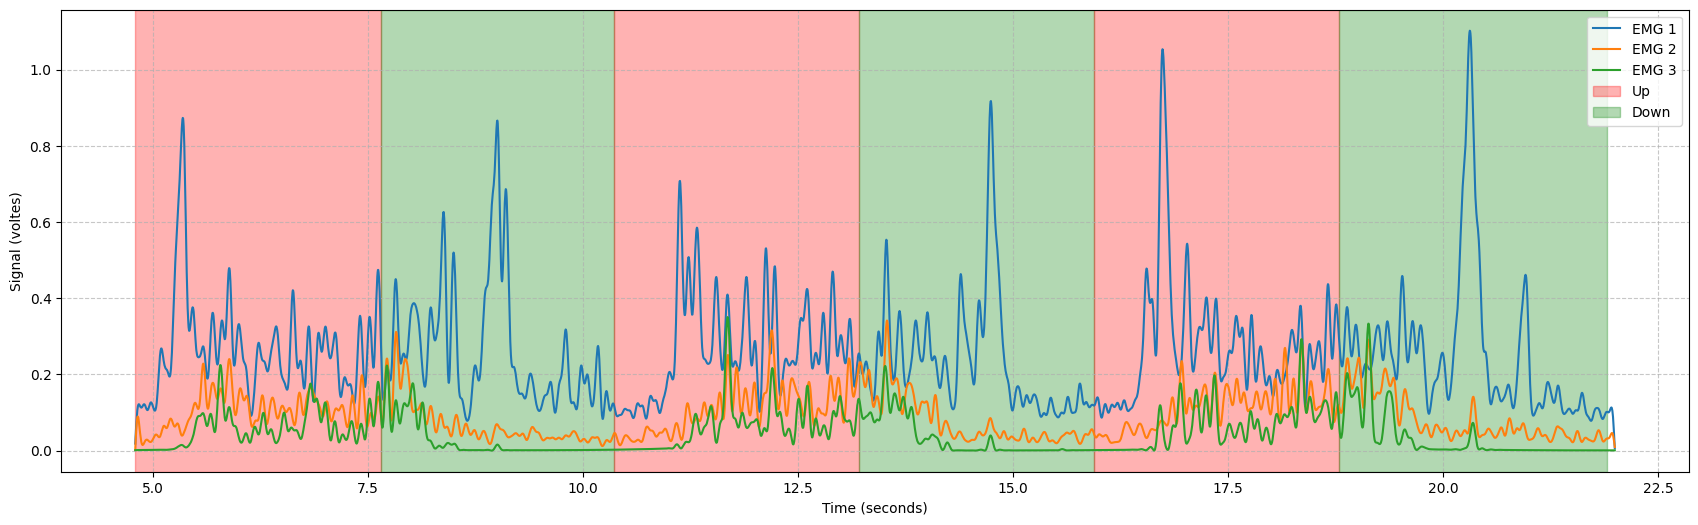

In [50]:
interval, emg, config = data_prepare("../data/sitting/exp_1", low_pass=40)

plt.figure(figsize=(21, 6))
plt.plot(interval, emg[:, 0], label="EMG 1")
plt.plot(interval, emg[:, 1], label="EMG 2")
plt.plot(interval, emg[:, 2], label="EMG 3")

plt.grid(True, linestyle="--", alpha=0.7)
plt.xlabel("Time (seconds)")
plt.ylabel("Signal (voltes)")
c = ["r", "g"]
periods = []
for i in range(3):
    t0 = np.argwhere(interval >= config[f"close_{i}"])[0][0]
    tf = np.argwhere(interval >= config[f"open_{i}"])[0][0]
    periods.extend([t0, tf])
periods.append(np.argwhere(interval >= 21.9)[0][0])
for i in range(len(periods) - 1):
    if i in [0, 1]:
        plt.axvspan(interval[periods[i]], interval[periods[i + 1]], color=c[i%2], alpha=0.3, label=f"{'Up' if i%2==0 else 'Down'}")
    else:
        plt.axvspan(interval[periods[i]], interval[periods[i + 1]], color=c[i%2], alpha=0.3)
plt.legend()
plt.show()

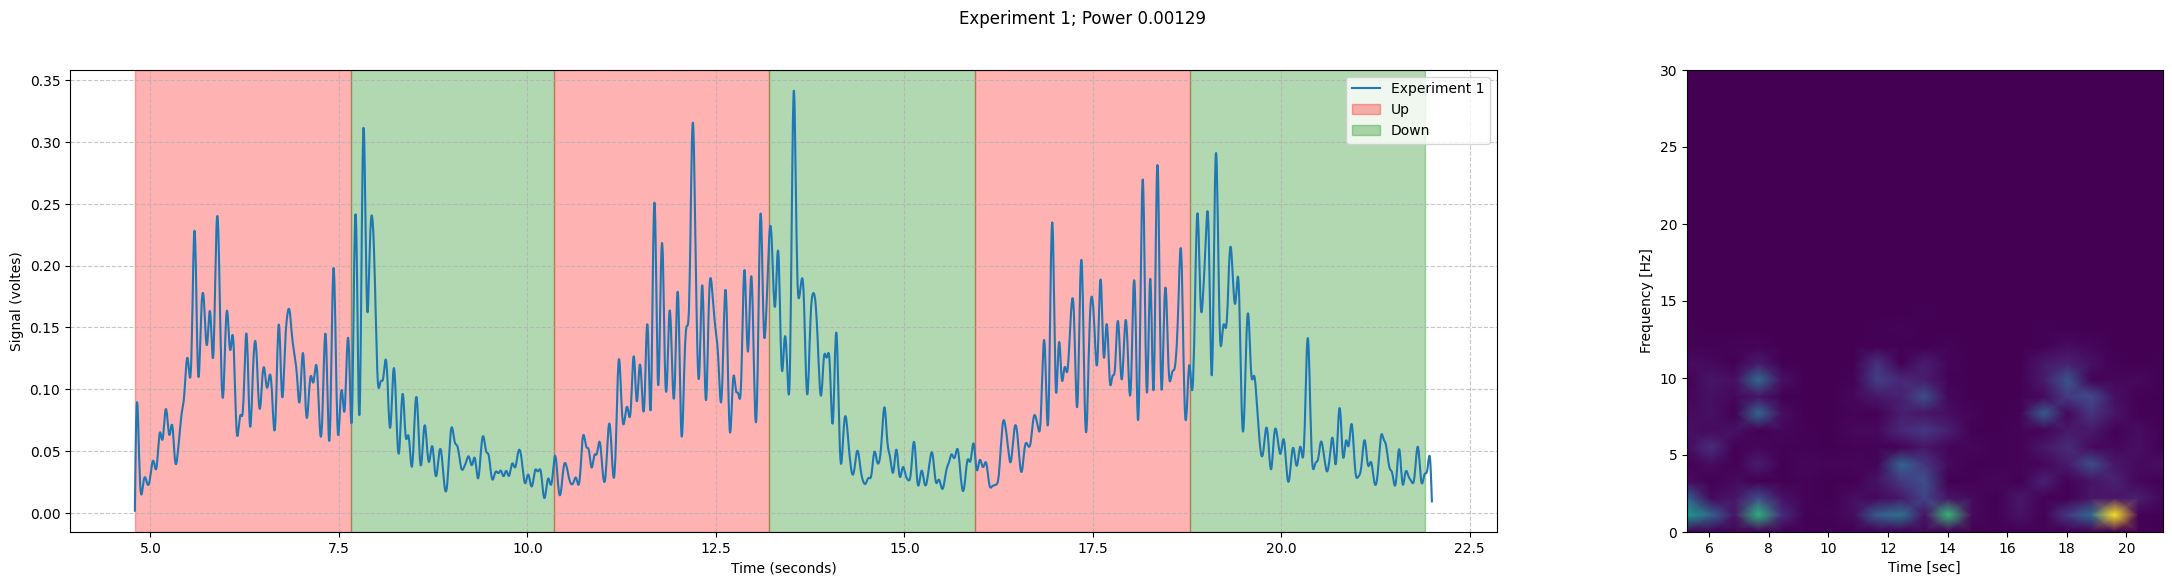

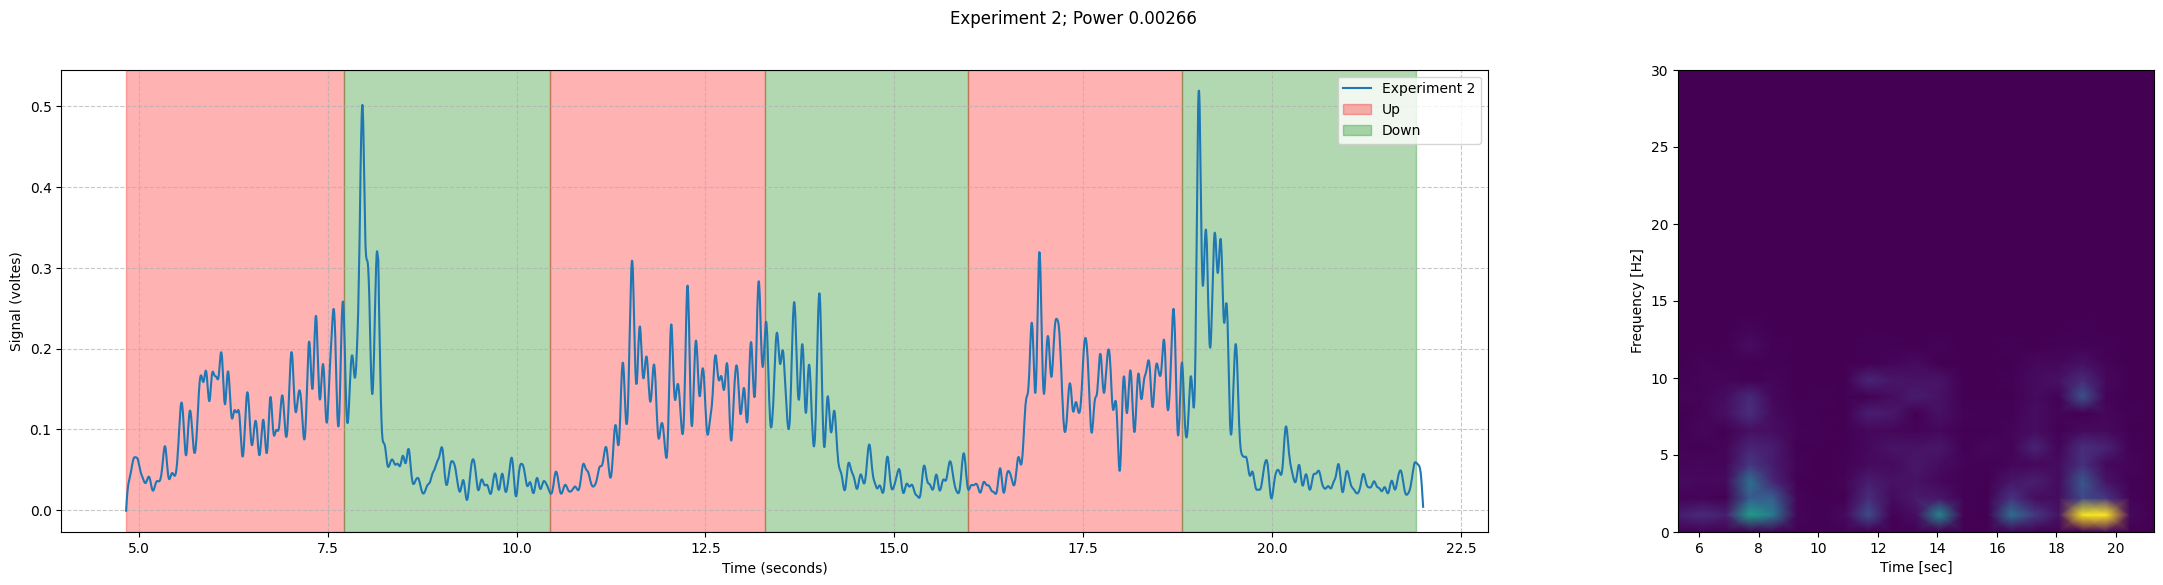

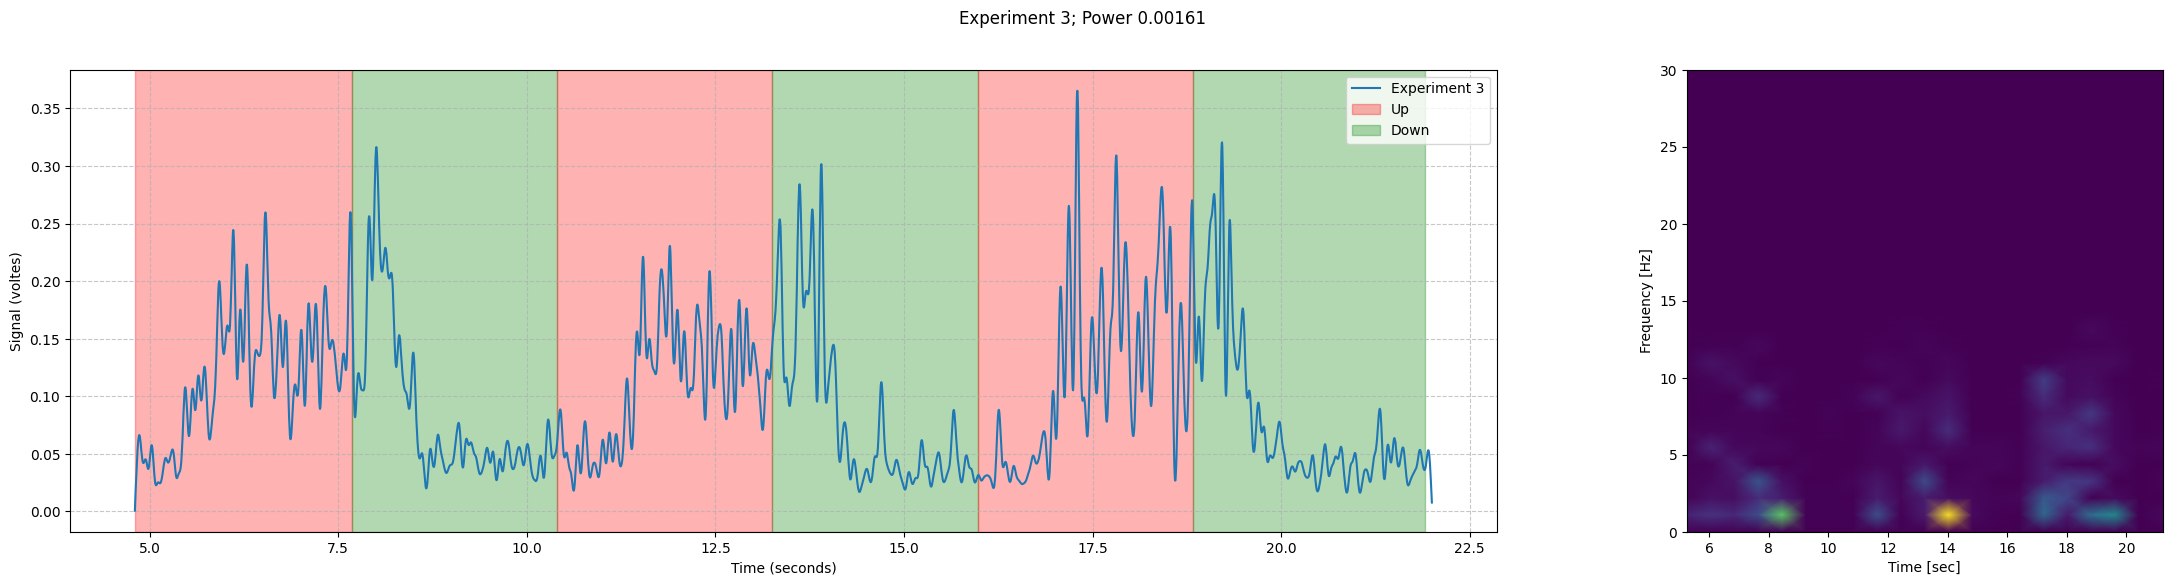

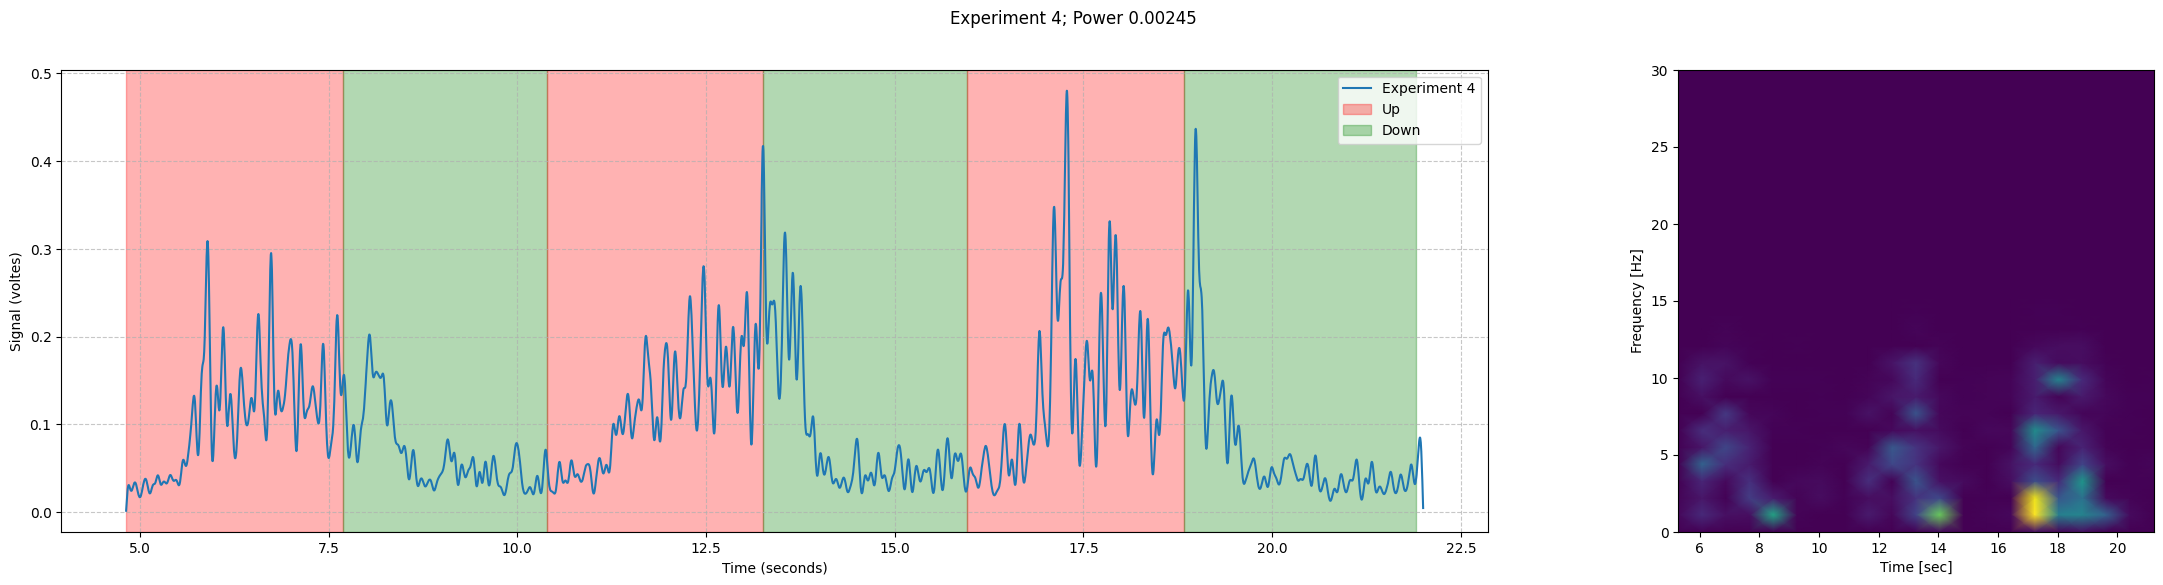

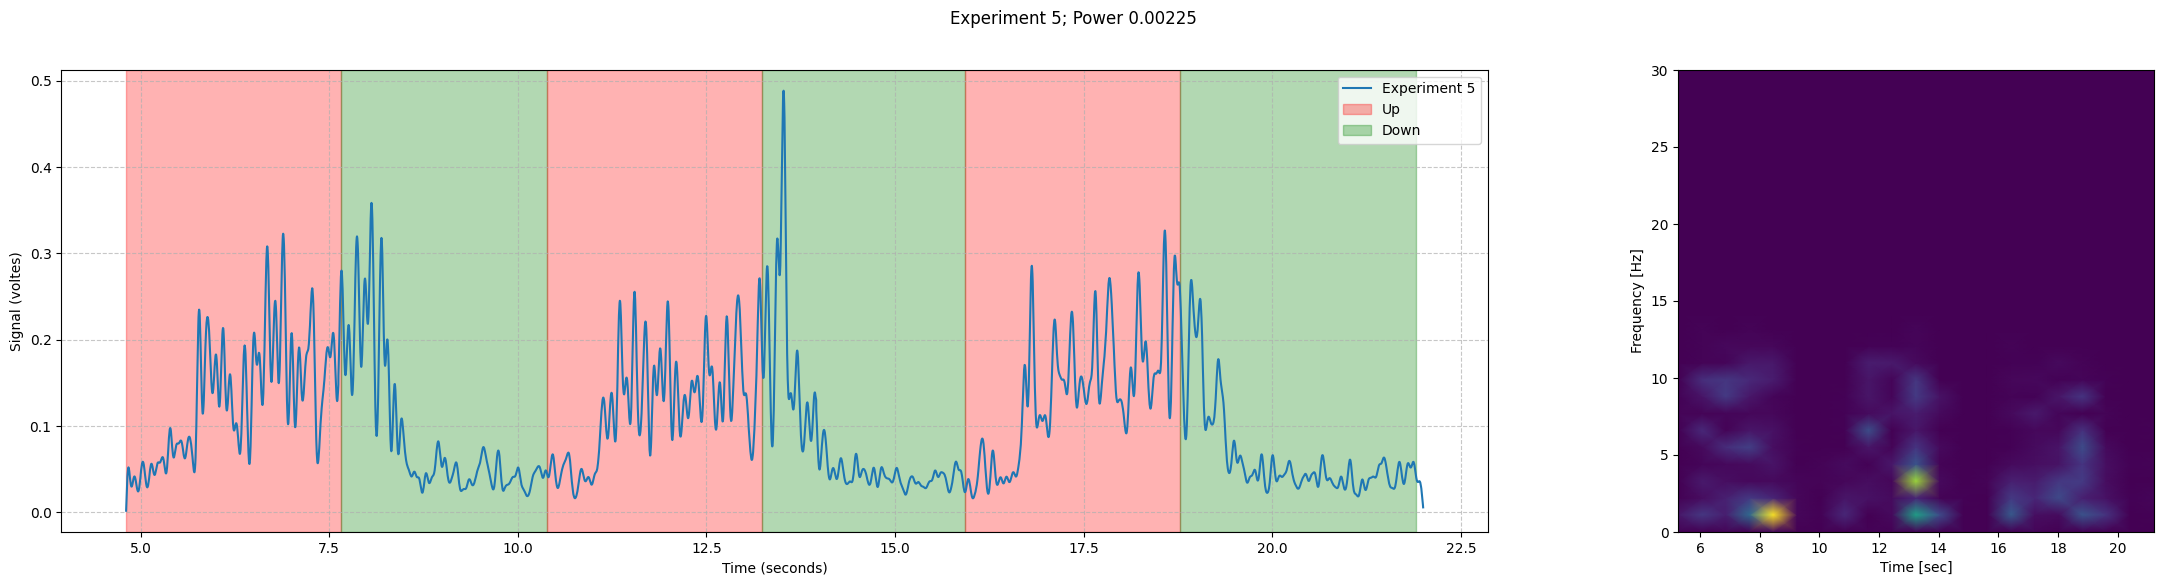

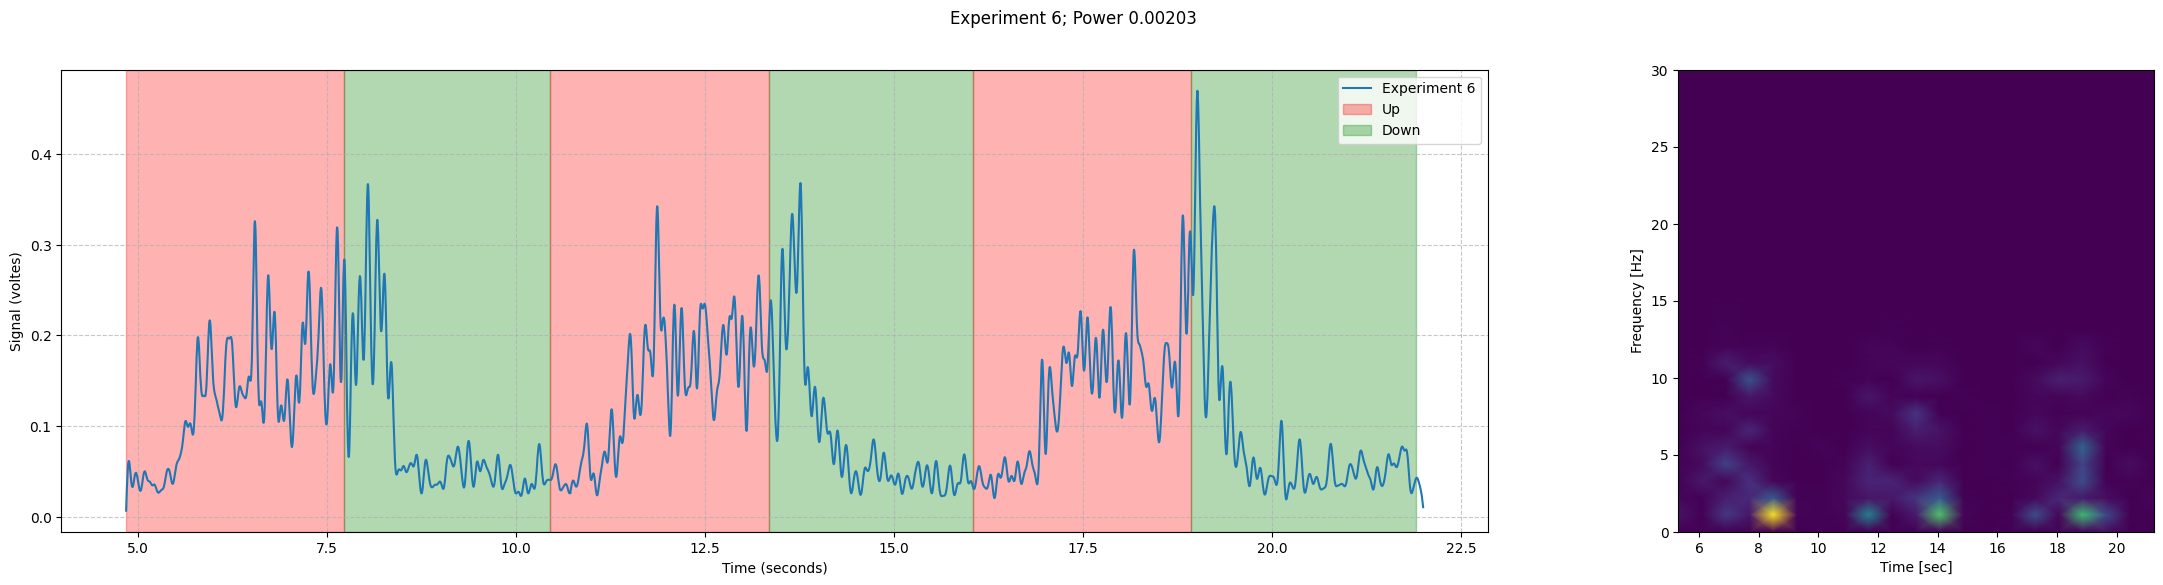

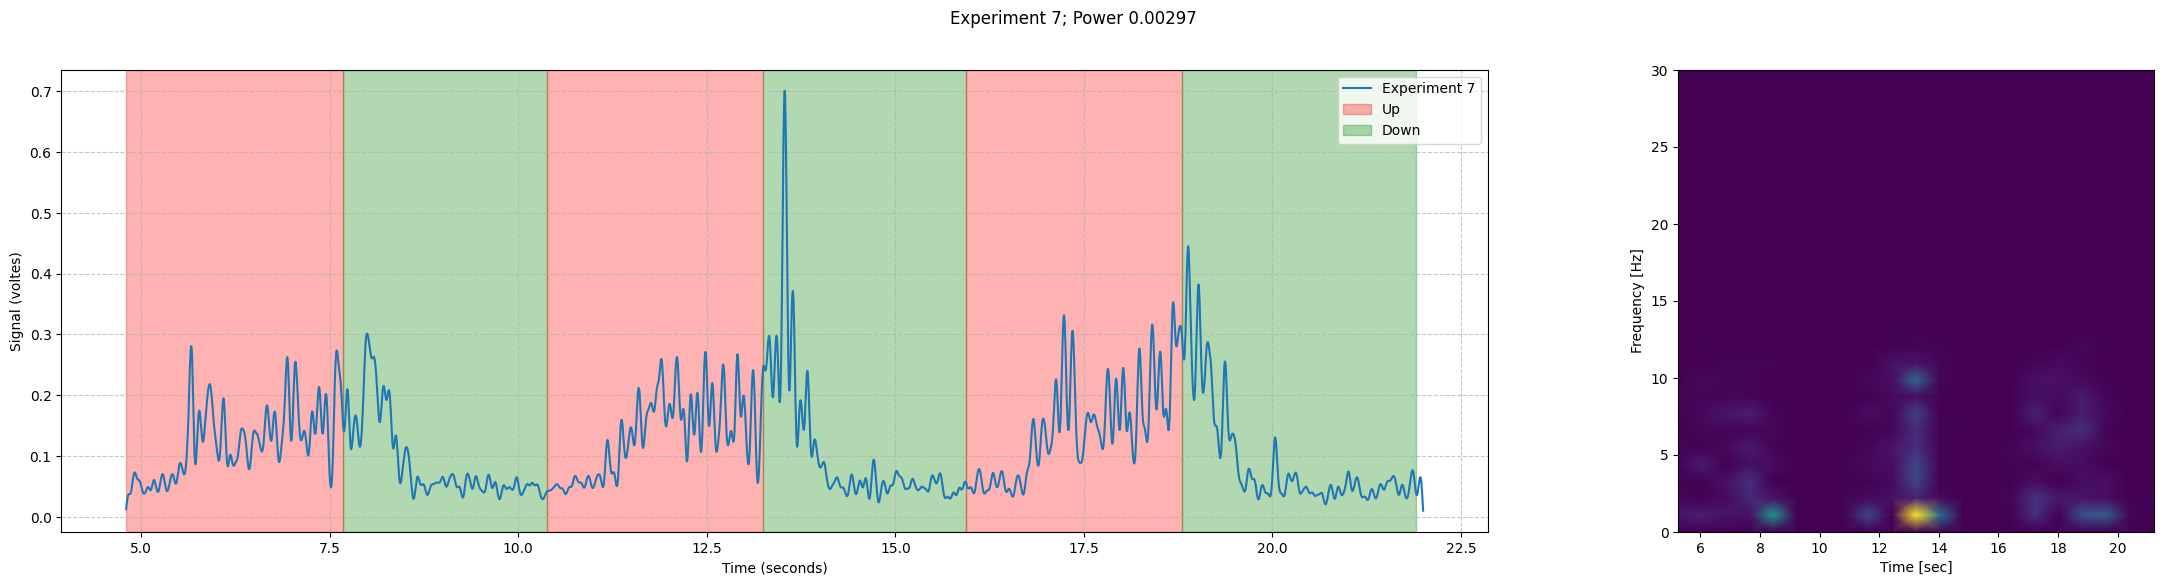

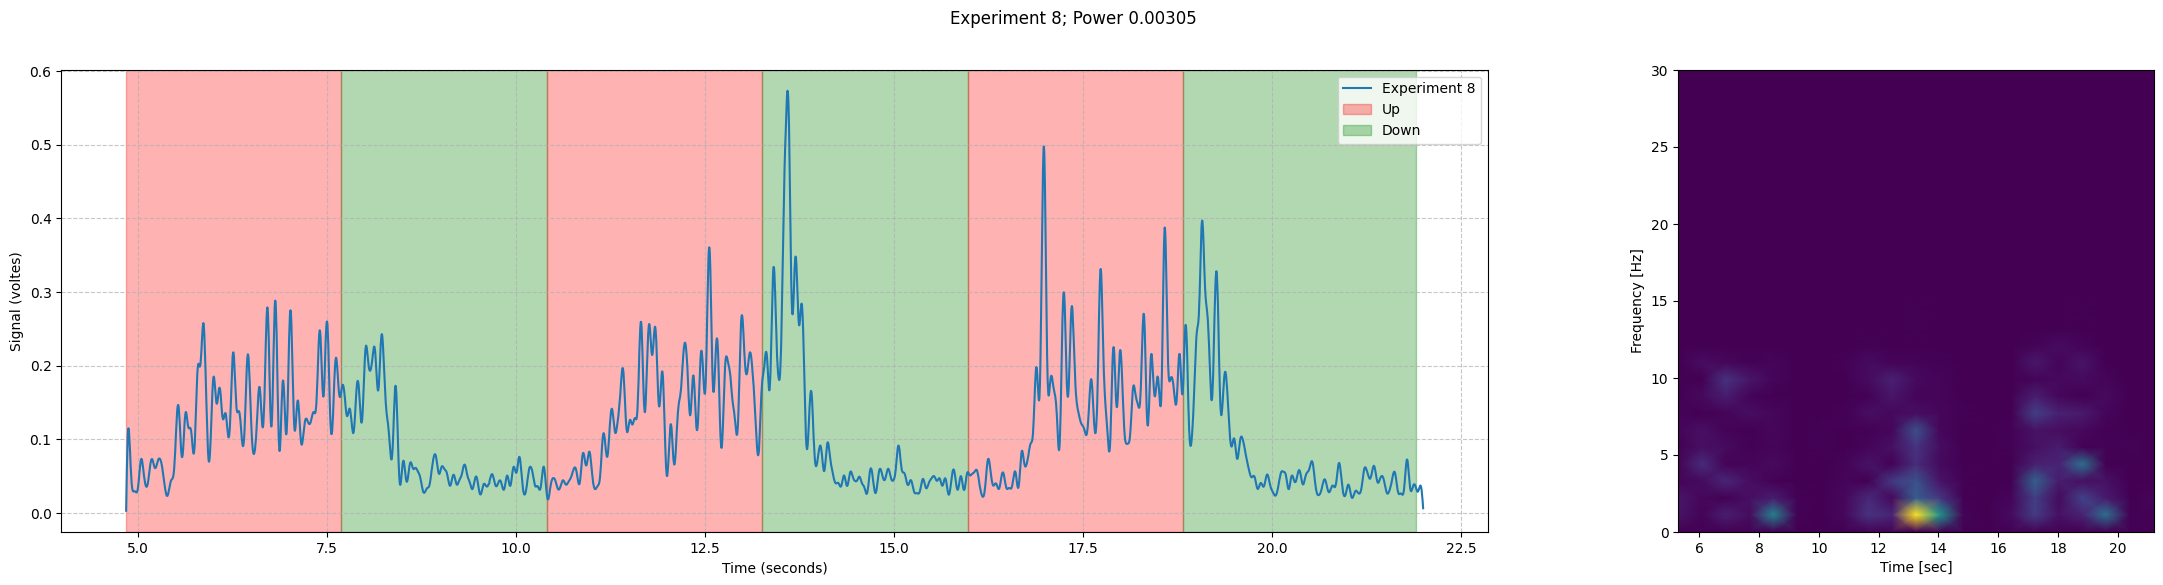

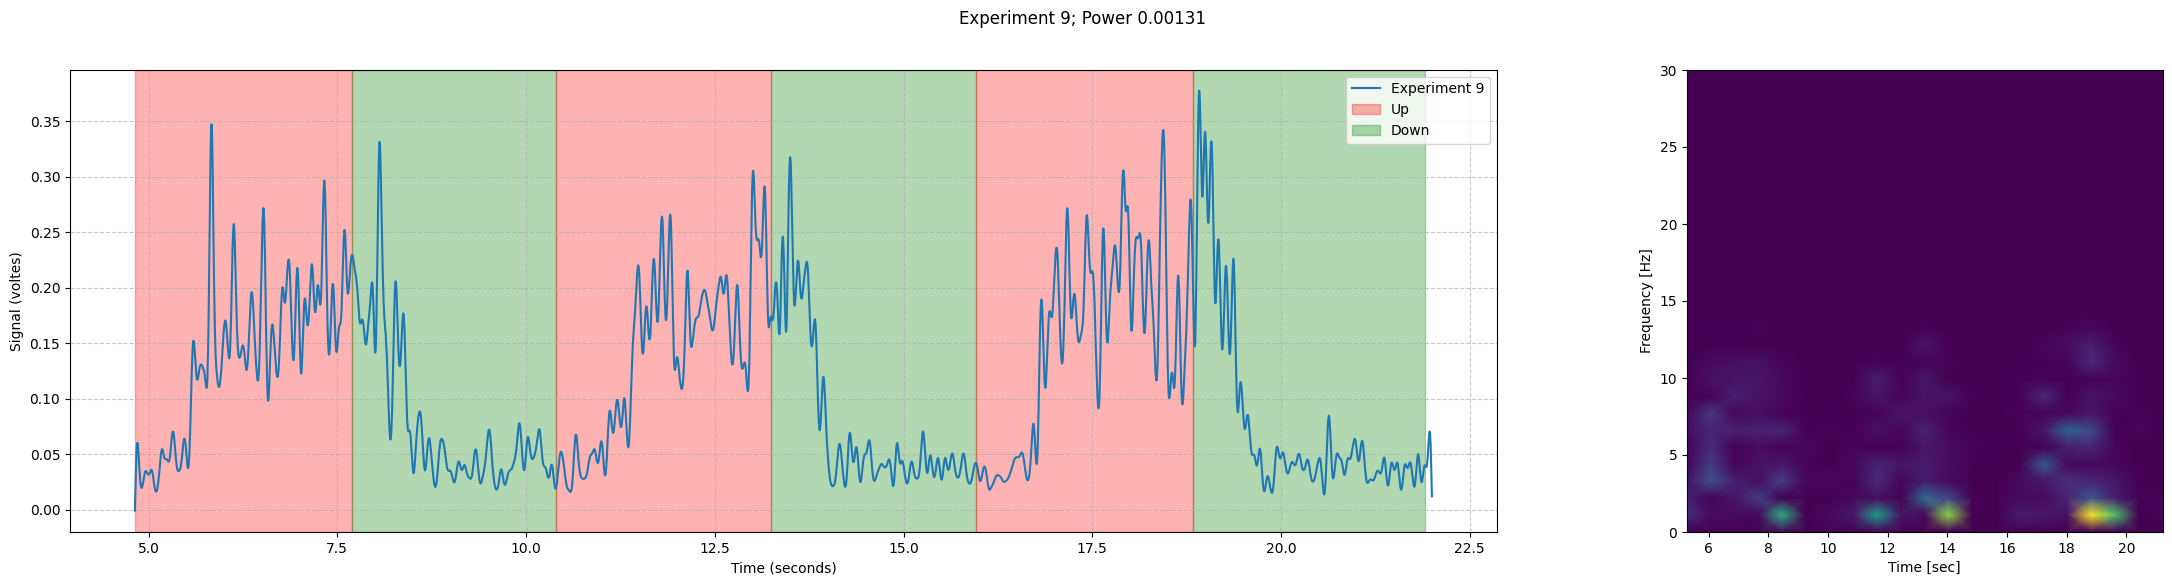

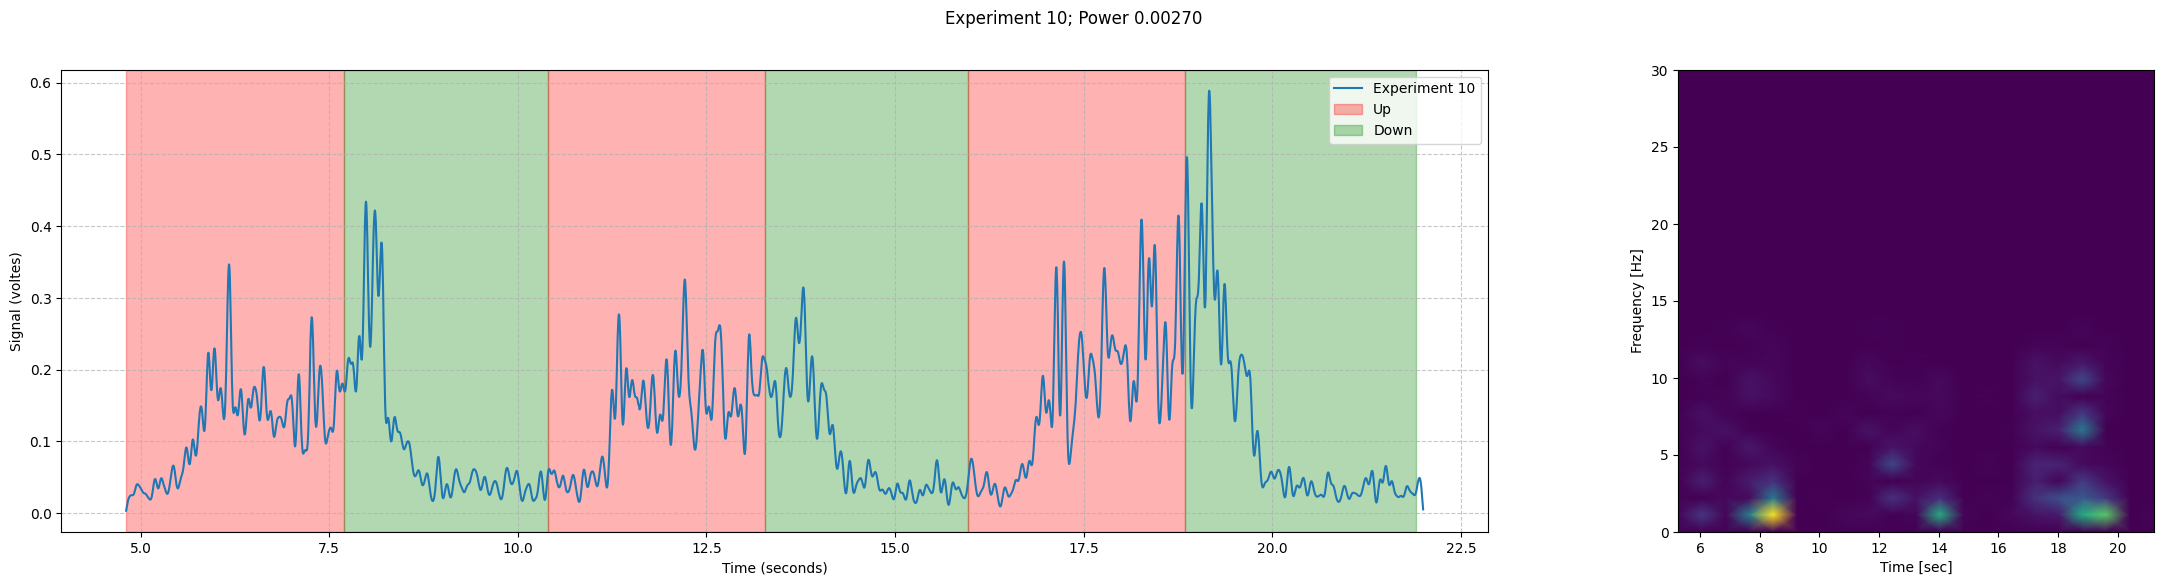

In [55]:
CHANNEL = 1
for exp in range(1, 11):
    interval, emg, config = data_prepare(f"../data/sitting/exp_{exp}", low_pass=40)

    f, P = welch(emg[:, CHANNEL], fs=1000, window='hann', noverlap=0, nfft=int(256.))
    area_freq = cumtrapz(P, f, initial=0)
    total_power = area_freq[-1]
    
    fig, axes = plt.subplots(1, 2, figsize=(27, 6), gridspec_kw={'width_ratios': [3, 1]})
    fig.suptitle(f"Experiment {exp}; Power {total_power:.5f}")

    axes[0].plot(interval, emg[:, CHANNEL], label=f"Experiment {exp}")

    axes[0].grid(True, linestyle="--", alpha=0.7)
    axes[0].set_xlabel("Time (seconds)")
    axes[0].set_ylabel("Signal (voltes)")
    c = ["r", "g"]
    periods = []
    for i in range(3):
        t0 = np.argwhere(interval >= config[f"close_{i}"])[0][0]
        tf = np.argwhere(interval >= config[f"open_{i}"])[0][0]
        periods.extend([t0, tf])
    periods.append(np.argwhere(interval >= 21.9)[0][0])
    for i in range(len(periods) - 1):
        if i in [0, 1]:
            axes[0].axvspan(interval[periods[i]], interval[periods[i + 1]], color=c[i%2], alpha=0.3, label=f"{'Up' if i%2==0 else 'Down'}")
        else:
            axes[0].axvspan(interval[periods[i]], interval[periods[i + 1]], color=c[i%2], alpha=0.3)
    axes[0].legend()

    f, t, Sxx = spectrogram(emg[:, CHANNEL], emg.shape[0] / (interval[-1] - interval[periods[0]]))
    axes[1].pcolormesh(t + interval[periods[0]], f, Sxx, shading='gouraud')
    axes[1].set_ylabel('Frequency [Hz]')
    axes[1].set_xlabel('Time [sec]')
    axes[1].set_ylim([0, 30])

    plt.show()